In [48]:
import yaml
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import pickle
import numpy as np
import networkx as nx
import copy
import os

with open(r"./configs/build_taxo.yml") as file:
    params_list = yaml.load(file, Loader=yaml.FullLoader)

In [2]:
class TaxonomyBuilder:
    def __init__(self, root, all_verteces, max_iter=10000):
        self.root = root
        self.all_verteces = all_verteces
        self.max_iter = max_iter

    def build_taxonomy(self, strategy, **kwargs):
        self.edge_collector = getattr(self, strategy)
        self.collector_params = kwargs

        # self.pbar = tqdm(total=34000)
        self.all_edges = []
        self.i = 0
        self.build_tree(self.root, self.all_verteces)
        # self.pbar.close()

    #   return self.all_edges

    def build_tree(self, root, possible_verteces):
        top_edges_idx = self.edge_collector(
            root, possible_verteces, **self.collector_params
        )
        new_pos_verteces = np.delete(possible_verteces, top_edges_idx)
        for new_edge_idx in top_edges_idx:
            self.all_edges.append((root, possible_verteces[new_edge_idx]))
            # self.pbar.update(1)
            self.i += 1
            if self.i > self.max_iter:
                break
            self.build_tree(possible_verteces[new_edge_idx], new_pos_verteces)

    @staticmethod
    def ppl_thr_collector(root, possible_verteces, **kwargs):
        ppls = np.array(
            [kwargs["ppl_pairs"][(root, vertex)] for vertex in possible_verteces]
        )
        return np.where(np.array(ppls) < kwargs["thr"])[0]

    @staticmethod
    def ppl_top_collector(root, possible_verteces, **kwargs):
        ppls = np.array(
            [kwargs["ppl_pairs"][(root, vertex)] for vertex in possible_verteces]
        )
        return np.argsort(ppls)[: min(kwargs["top_k"], len(ppls))]


def clean_dict(pairs, use_lemma, reverse):
    new_pairs = {}
    for key, val in pairs.items():
        if use_lemma:
            term = key[0].split("(")[0].strip()
        else:
            term = key[0]
        target = key[1].split(",")[0]
        new_key = (target, term) if reverse else (term, target)
        new_pairs[new_key] = val

    return new_pairs


def iterative_child(ppl_pairs, low, high, step, max_iter):
    thrs = np.arange(low, high, step)
    Fs = []
    for thr in tqdm(thrs):
        tb = TaxonomyBuilder(root, all_verteces, max_iter)
        tb.build_taxonomy("ppl_thr_collector", ppl_pairs=ppl_pairs, thr=thr)
        edges = tb.all_edges

        P = len(set(G.edges()) & set(edges)) / (len(set(edges)) + 1)
        R = len(set(G.edges()) & set(edges)) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)

        #  print('precision: {} \n recall: {} \n F-score: {}'.format(P,R,F))
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs


def brute_child(ppl_pairs, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    for thr in tqdm(thrs):
        edges = []
        for key, val in ppl_pairs.items():
            if val < thr:
                edges.append(key)

        P = len(set(G.edges()) & set(edges)) / (len(set(edges)) + 1e-15)
        R = len(set(G.edges()) & set(edges)) / len(set(G.edges()))
        # print(len(set(edges)))
        F = (2 * P * R) / (P + R + 1e-15)

        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs

In [3]:
def get_graph(ppl_pairs, thr):
    S = nx.DiGraph()
    for key, val in ppl_pairs.items():
        if val <thr:
            S.add_edge(key[0], key[1], weight=val)
    return S
        

In [4]:
def brute_resolve(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
    
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = ppl_reverse[edge]
                    ppls[edge] = weight_reverse
                
                # if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()): #эвристика, чтобы не выкидывать ребра с близкими перплексиями

                max_ppl_key = max(ppls, key=ppls.get) 
                counter +=1
                S.remove_edge(*max_ppl_key)

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts


###  Построение по гипонимам, отбрасывала ребра по гиперонимам

100%|██████████████████████████████████████| 2990/2990 [00:27<00:00, 109.24it/s]


0.13510253317249654 5.389999999999997


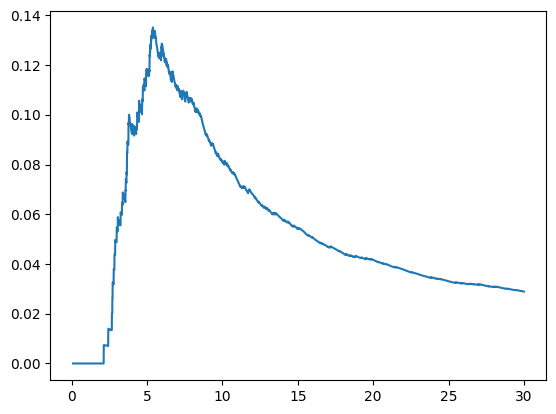

In [97]:
res = brute_child(ppls_pairs, low=low, high=high, step=step)

In [98]:
max(res)

0.13510253317249654

### Построение по гиперонимам и просто сравнение перплексий ребер, с наибольшей перплексией выкидываем

100%|███████████████████████████████████████| 2990/2990 [02:25<00:00, 20.55it/s]


0.4026548672566367 2.489999999999999


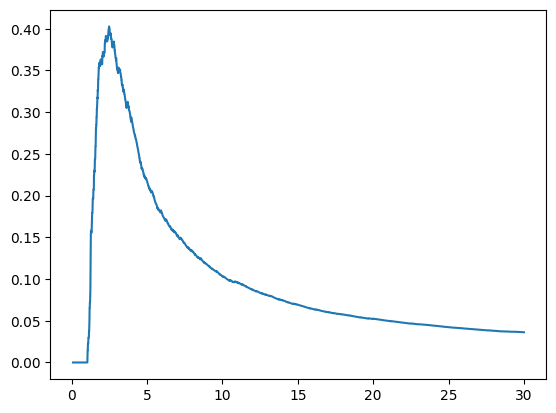

In [104]:
if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=False)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res1, counter = brute_resolve(ppls_pairs, ppl_reverse, low=low, high=high, step=step)

In [105]:
max(counter)

53

### Пробовала рассчитывать через отбрасывание через обратные перплексии

In [6]:
def brute_resolve_summation(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
    
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:

                    weight_reverse = np.array(ppl_reverse[(edge[1], edge[0])])
                    weight_straight = np.array(ppl_reverse[edge])

                    summation = weight_reverse + weight_straight
                    ppls[edge] = summation
                
                    
                max_ppl_key = max(ppls, key=ppls.get) 
                counter +=1
                S.remove_edge(*max_ppl_key)

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)
        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts

100%|██████████████████████████████████████████████████████████████| 2990/2990 [01:52<00:00, 26.55it/s]


0.376106194690265 2.489999999999999


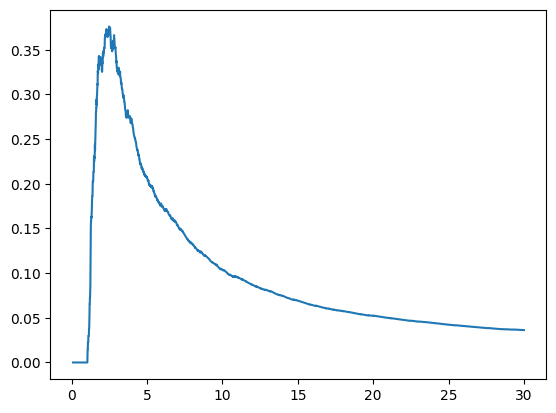

In [7]:
res_sum = brute_resolve_summation(ppls_pairs, ppl_reverse, low, high, step)

### Без петель  
Улучшения в скоре не дало, видимо петли и так отбрасываются трешхолдом.

100%|███████████████████████████████████████████████████████████████████████████████| 2990/2990 [02:02<00:00, 24.50it/s]


0.4026548672566367 2.489999999999999


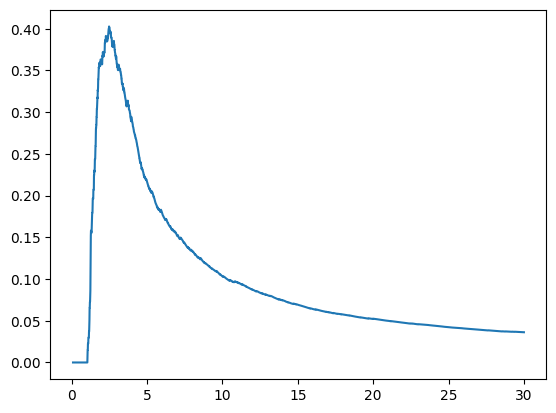

In [16]:
def brute_resolve_noloops(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)

        counter += nx.number_of_selfloops(S)
        S.remove_edges_from(nx.selfloop_edges(S))
        

        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = S[edge[0]][edge[1]]['weight']
                    ppls[edge] = weight_reverse
                
                # if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()): #эвристика, чтобы не выкидывать ребра с близкими перплексиями

                max_ppl_key = max(ppls, key=ppls.get) 
                counter +=1
                S.remove_edge(*max_ppl_key)



        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)

        Fs.append(F)

    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)

    return Fs, counts

if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=reverse)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res_best, counts = brute_resolve_noloops(ppls_pairs, ppl_reverse, low=low, high=high, step=step)

In [79]:
max(counts)

62

### Лучший вариант  
Просто через сравнение перплексий ребер.  
Прирост по сравнению с просто brute_child на очищенном датасете небольшой: **0.386 -> 0.402**

100%|███████████████████████████████████████| 2990/2990 [01:58<00:00, 25.13it/s]


0.4026548672566367 2.489999999999999


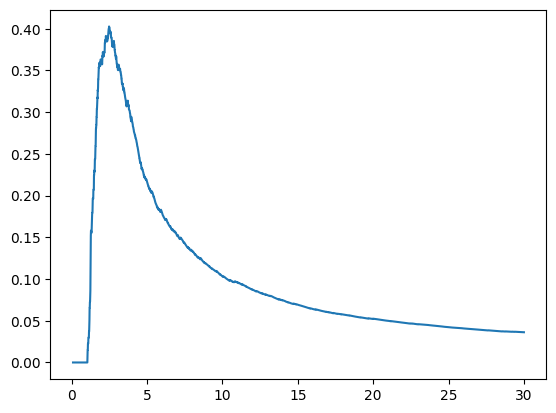

In [7]:
def brute_resolve(ppl_pairs, ppl_reverse, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
    
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = S[edge[0]][edge[1]]['weight']
                    ppls[edge] = weight_reverse
                
                # if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()): #эвристика, чтобы не выкидывать ребра с близкими перплексиями

                max_ppl_key = max(ppls, key=ppls.get) 
                counter +=1
                S.remove_edge(*max_ppl_key)

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)

        Fs.append(F)


    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts


if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=reverse)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res_best, counter = brute_resolve(ppls_pairs, ppl_reverse, low=low, high=high, step=step)

In [119]:
max(counter)

62

### Меньше свзяных компонент  
В золотом стандарте для английского 1 связная компонента, решила подумать над добавлением ребер для бОльшей связности. Через выбор по перплексиям не получилось, скор упал

In [25]:
def make_connection(G, G_start):
    cc = sorted(nx.weakly_connected_components(G))
    if len(cc) <= 1:
        return G
    else:
        cc_main, cc_tomatch = cc[0], cc[1:]

        minimum = {}
        # print(len(cc), len(cc_tomatch))
        for comp in cc_tomatch:
            node_to_consider = {}

            for node in comp:
                weight_in = list(G_start.in_edges(node, data="weight"))
                # print(G_start.in_edges(node, data="weight"))
                weight_out = list(G_start.out_edges(node, data="weight"))
                weight = [(start, end, weight) for start, end, weight in weight_in+weight_out if end in cc_main]
                if weight:
                    weight = min(weight, key = lambda t: t[2])
                else:
                    weight = [1e+10, 1e+10, 1e+10]



                node_to_consider[node] = (weight[2], weight[0])
            # print(node_to_consider)
            minimum = min(node_to_consider, key=node_to_consider.get)

            G.add_edge(minimum, node_to_consider[minimum][1], weight=node_to_consider[minimum][0])

        return G





100%|███████████████████████████████████████████████████████████████████████████████| 2990/2990 [02:37<00:00, 18.95it/s]


0.3847780126849889 2.489999999999999


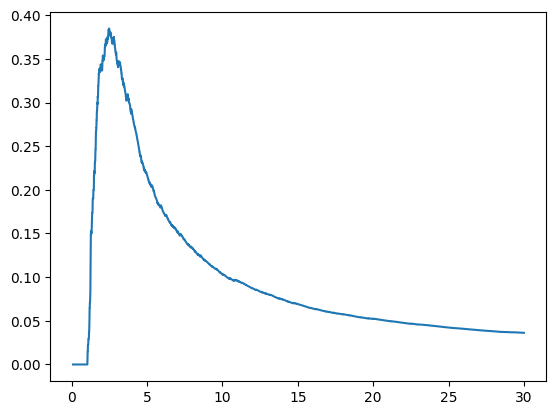

In [30]:
def brute_resolve_less_cc(ppl_pairs, low, high, step):
    thrs = np.arange(low, high, step)
    Fs = []
    counts = []
    for thr in tqdm(thrs):
        counter = 0
        S = get_graph(ppl_pairs, thr)
        # print(len(list(S.edges())))
        S_start = get_graph(ppl_pairs, thr)
        for node in S.nodes():
            if S.in_degree(node) == 2:
                edges_q = S.in_edges(node)
                ppls = {} #попробовать еще через сумму перплексий в одну сторону + другую сторону, с макс суммой выбросить ребро

                for edge in edges_q:
                    weight_reverse = S[edge[0]][edge[1]]['weight']
                    ppls[edge] = weight_reverse
                
                if abs(list(ppls.values())[0]-list(ppls.values())[1]) < min(ppls.values()): #эвристика, чтобы не выкидывать ребра с близкими перплексиями

                    max_ppl_key = max(ppls, key=ppls.get) 
                    counter +=1
                    S.remove_edge(*max_ppl_key)
                
        S = make_connection(S, S_start)
        # print(len(list(S.edges())))

        P = len(set(G.edges()) & set(S.edges())) / (len(set(S.edges())) + 1)
        R = len(set(G.edges()) & set(S.edges())) / len(set(G.edges()))
        F = (2 * P * R) / (P + R + 1e-15)
        counts.append(counter)

        Fs.append(F)


    print(max(Fs), thrs[np.argmax(Fs)])
    plt.plot(thrs, Fs)
    return Fs, counts


if __name__ == "__main__":
    data = params_list["DATA"][0]
    in_name = params_list["IN_NAME"][0]
    compare_name = params_list["COMPARE_NAME"][0]
    lemma = params_list["LEMMA"][0]
    reverse = params_list["REVERSE"][0]
    low = params_list["LOW"][0]
    high = params_list["HIGH"][0]
    step = params_list["STEP"][0]

    # print(data, in_name, lemma, reverse, low, high, step, sep='\n')
    path = "gs_taxo/EN/" + str(data) + "_eurovoc_en.taxo"
    G = nx.DiGraph()

    with open(path, "r") as f:
        for line in f:
            idx, hypo, hyper = line.split("\t")
            hyper = hyper.replace("\n", "")
            G.add_node(hypo)
            G.add_node(hyper)
            G.add_edge(hyper, hypo)

    with open(in_name, "rb") as f:
        ppls = pickle.load(f)


    ppls_pairs = clean_dict(ppls, use_lemma=lemma, reverse=reverse)

    with open(compare_name, "rb") as f1:
            ppls_c = pickle.load(f1)

    ppl_reverse = clean_dict(ppls_c, use_lemma=lemma, reverse=reverse)


    root = data
    all_verteces = list(G.nodes)
    all_verteces.remove(root)

    #  print(ppls_pairs)
    res_best_less_cc, counter = brute_resolve_less_cc(ppls_pairs, low=low, high=high, step=step)

### Подсчет нод

In [98]:
S_new = get_graph(ppls_pairs, 10)

In [99]:
def get_num_pairs(graph):
    parentsnum = {}
    if not os.path.exists('./multiple_parents_thr=10'):
        os.mkdir('./multiple_parents_thr=10')
    for i in tqdm(range(2, 25)):
        filename = f'./multiple_parents_thr=10/{i}_parents.pickle'
        counter = 0
        pairs = []
        for node in graph.nodes():
            if graph.in_degree(node) == i:
                counter += 1
                pairs.append(graph.in_edges(node))
        
        with open(filename, 'wb') as f:
            pickle.dump(pairs, f)

        parentsnum[str(i)+' parents'] = counter
    
    return parentsnum

In [100]:
diction_10= get_num_pairs(S_new)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 214.72it/s]


In [92]:
diction_opt = get_num_pairs(S_new)

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1633.85it/s]


In [101]:
print(diction_10, diction_opt, sep='\n')

{'2 parents': 6, '3 parents': 10, '4 parents': 13, '5 parents': 11, '6 parents': 8, '7 parents': 13, '8 parents': 12, '9 parents': 17, '10 parents': 21, '11 parents': 17, '12 parents': 16, '13 parents': 11, '14 parents': 5, '15 parents': 7, '16 parents': 12, '17 parents': 10, '18 parents': 3, '19 parents': 8, '20 parents': 5, '21 parents': 4, '22 parents': 7, '23 parents': 9, '24 parents': 1}
{'2 parents': 35, '3 parents': 18, '4 parents': 2, '5 parents': 1, '6 parents': 0, '7 parents': 0, '8 parents': 0, '9 parents': 0, '10 parents': 0, '11 parents': 0, '12 parents': 0, '13 parents': 0, '14 parents': 0, '15 parents': 0, '16 parents': 0, '17 parents': 0, '18 parents': 0, '19 parents': 0, '20 parents': 0, '21 parents': 0, '22 parents': 0, '23 parents': 0, '24 parents': 0}


In [106]:
print('Mean number of parents with thr=10: ', np.mean(np.array(list(diction_10.values()))))
print('Mean number of parents with thr=optimal (2.49): ', np.mean(np.array(list(diction_opt.values()))))

Mean number of parents with thr=10:  9.826086956521738
Mean number of parents with thr=optimal (2.49):  2.4347826086956523
